In [1]:
import requests
import gzip
import cfgrib
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from datetime import datetime
from metpy.plots import USCOUNTIES
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:

# Latest 
url = "https://mrms.ncep.noaa.gov/data/2D/MESH/MRMS_MESH.latest.grib2.gz"
# Archived 
url = 'https://mtarchive.geol.iastate.edu/2024/05/20/mrms/ncep/MESH/MESH_00.50_20240520-191200.grib2.gz'

response = requests.get(url)
with open("MRMS_MESH.latest.grib2.gz", "wb") as f:
    f.write(response.content)
with gzip.open("MRMS_MESH.latest.grib2.gz", 'rb') as f_in:
    with open("MRMS_MESH.latest.grib2", 'wb') as f_out:
        f_out.write(f_in.read())

ds = xr.open_dataset('MRMS_MESH.latest.grib2', engine='cfgrib')
print(ds)

<xarray.Dataset>
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] ...
    step            timedelta64[ns] ...
    heightAboveSea  float64 ...
  * latitude        (latitude) float64 54.99 54.98 54.98 ... 20.03 20.02 20.01
  * longitude       (longitude) float64 230.0 230.0 230.0 ... 300.0 300.0 300.0
    valid_time      datetime64[ns] ...
Data variables:
    unknown         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2024-05-23T14:09 GRIB to CDM+CF via cfgrib-0.9.1...


In [3]:
unknown = ds['unknown']  / 25.4
dt = datetime.utcfromtimestamp(unknown.time.values.astype(datetime)/1e9)
formatted_dt = dt.strftime("%Y-%m-%d %H:%M")

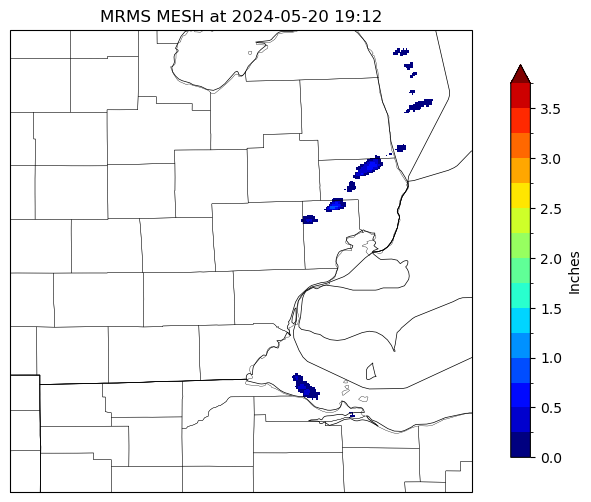

In [4]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([-85, -82, 41, 44])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25)

img = unknown.plot(ax=ax, levels=np.arange(0, 4, 0.25), cmap='jet', extend='max', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

cbar = plt.colorbar(img, ax=ax, shrink=0.85, extend='max')
cbar.set_label('Inches')

plt.title('MRMS MESH at {}'.format(formatted_dt))
plt.show()

In [5]:
probsvr_url = 'https://mtarchive.geol.iastate.edu/2024/05/20/mrms/ncep/ProbSevere/MRMS_PROBSEVERE_20240520_191200.json'

response = requests.get(probsvr_url)
probsvr_data = response.json()

print(probsvr_data)

{'source': 'NOAA/NCEP Central Operations', 'product': 'ProbSevere', 'validTime': '20240520_191236 UTC', 'productionTime': '20240520_191411 UTC', 'machine': 'vm-cprk-mrms-ops-probsvr1.ncep.noaa.gov', 'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-82.06, 24.4], [-82.0, 24.4], [-81.93, 24.35], [-81.89, 24.33], [-81.87, 24.33], [-81.85, 24.3], [-81.86, 24.26], [-81.89, 24.24], [-81.96, 24.24], [-82.05, 24.33], [-82.05, 24.37], [-82.06, 24.38], [-82.06, 24.4]]]}, 'models': {'probsevere': {'PROB': '1', 'LINE01': 'ProbHail: 0%; ProbWind: 1%; ProbTor: 0%', 'LINE02': '- MESH: 0.45 in.', 'LINE03': '- VIL Density: 1.46 g/m^3', 'LINE04': '- Flash Rate: 5 fl/min', 'LINE05': '- Flash Density (max in last 30 min): 0.86 fl/min/km^2', 'LINE06': '- Max LLAzShear: 0.008 /s', 'LINE07': '- 98% LLAzShear: 0.006 /s', 'LINE08': '- 98% MLAzShear: 0.004 /s', 'LINE09': '- Norm. vert. growth rate: N/A', 'LINE10': '- EBShear: 19.6 kts; SRH 0-1km AGL

C:\Users\Tony\AppData\Local\Temp\ipykernel_8396\2915613139.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  polygon = plt.Polygon(coordinates[0], fill=False, color=color, edgecolor='black', linewidth=3)


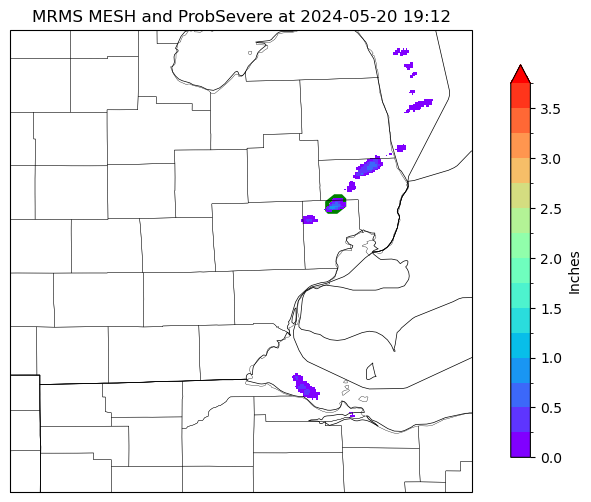

In [7]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

features = probsvr_data['features']
for feature in features:
    probwind = int(feature['models']['probwind']['PROB'])
    probhail = int(feature['models']['probhail']['PROB'])
    probtor = int(feature['models']['probtor']['PROB'])
    coordinates = feature['geometry']['coordinates']
    max_prob = max(probwind, probhail, probtor)
    if max_prob > 40:
        if max_prob == probwind:
            color = 'blue'
        elif max_prob == probhail:
            color = 'green'
        elif max_prob == probtor:
            color = 'red'
    else:
        continue  
    polygon = plt.Polygon(coordinates[0], fill=False, color=color, edgecolor='black', linewidth=3)
    ax.add_patch(polygon)

ax.set_extent([-85, -82, 41, 44])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25)

img = unknown.plot(ax=ax, levels=np.arange(0, 4, 0.25), cmap='rainbow', extend='max', transform=ccrs.PlateCarree(), add_colorbar=False)
cbar = plt.colorbar(img, ax=ax, shrink=0.85, extend='max')
cbar.set_label('Inches')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('MRMS MESH and ProbSevere at {}'.format(formatted_dt))
plt.show()